In [2]:
import torch
import math
import torch.nn as nn
from flows import PlanarFlow
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
from NormVAE import FlowVAE, BernoulliDecoder, LogitNormalDecoder

In [3]:
def prepare_dataset(dataset_name, batch_size, train=True):
    data = {
        'mnist': datasets.MNIST('datasets', train=train, download=True, transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).type(x.type())])),
        'cifar10': datasets.CIFAR10('datasets', train=train, download=True, transform=transforms.Compose(
            # ToTensor will
        [transforms.RandomCrop([8, 8]), transforms.ToTensor(), lambda x: (0.999 - 0.001) * x + 0.001]))
    }
    dataloader = torch.utils.data.DataLoader(data[dataset_name], batch_size=batch_size, shuffle=train)
    return dataloader

dataloader = prepare_dataset('mnist', 32)

Files already downloaded and verified


In [11]:
num_epoch = 100
dataset_name = 'mnist' #'cifar10'
img_size = [1, 28 ,28] if dataset_name=='mnist' else [3, 8, 8]
batch_size = 256
num_flow = 10
dim_z = 40
dim_h = 256

def train(model, dataset_name):
    if dataset_name == 'mnist':
        recon_loss = nn.BCELoss(reduction='sum')
    elif dataset_name == 'cifar10':
        recon_loss = nn.MSELoss(reduction='sum')
    dataloader = prepare_dataset(dataset_name, batch_size)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    for epoch in range(num_epoch):
        t = tqdm(enumerate(dataloader), total=len(dataloader))
        epoch_loss = []
        for i, (x, _) in t:
            # with torch.autograd.set_detect_anomaly(True):

            optimizer.zero_grad()
            x = x.reshape([-1, x.shape[1]*x.shape[2]*x.shape[3]])
            likelihood, kl = model(x)
            recon_loss_ = -likelihood.log_prob(x).sum() / len(x)
            kl_loss_ = kl.mean()
            loss = recon_loss_ + kl_loss_
            loss.backward()
            epoch_loss.append(loss.item())
            min_ln_loss_ = min([val.sum() for val in -likelihood.log_prob(x)])
            max_ln_loss_ = max([val.sum() for val in -likelihood.log_prob(x)])
            min_kl_loss_ = kl.min()
            max_kl_loss_ = kl.max()
            t.set_description("Recon loss %f (min-max %f %f), KL %f (min-max %f %f)" % 
                              (recon_loss_, min_ln_loss_, max_ln_loss_,
                               kl_loss_, min_kl_loss_, max_kl_loss_))
            optimizer.step()

def test():
    pass

In [12]:
if dataset_name == 'mnist':
    decoder = BernoulliDecoder(img_size, dim_z, dim_h)
elif dataset_name == 'cifar10':
    decoder = LogitNormalDecoder(img_size, dim_z, dim_h)
flows = [PlanarFlow(dim_z) for _ in range(num_flow)]
model = FlowVAE(img_size, dim_h, dim_z, flows, decoder)
train(model, dataset_name)

Files already downloaded and verified


Recon loss 122.625343 (min-max 34.884624 214.159866), KL 27.874029 (min-max 25.680771 32.507782): 100%|██████████| 235/235 [00:22<00:00, 10.29it/s] 


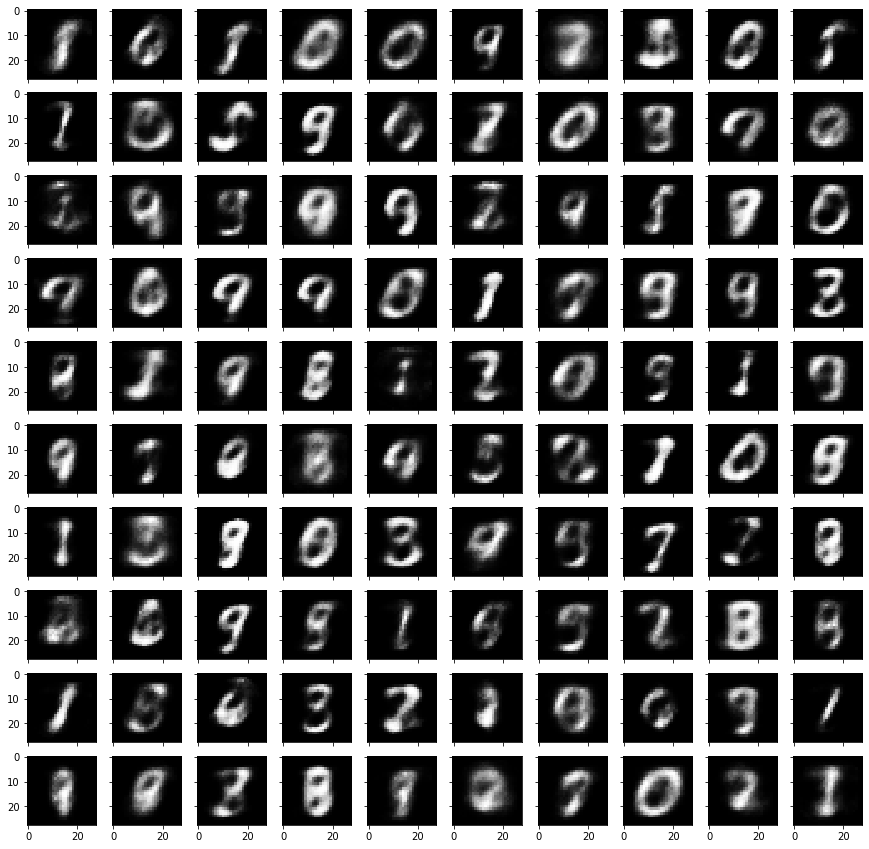

In [13]:
# Plotting the mnist or cifar image
rows=10
cols=10
fig, ax = plt.subplots(rows, cols, figsize=(15,15), sharex='col', sharey='row')
counter=0
for i in range(rows*cols):
    q, mod = divmod(i,cols)
    if dataset_name == 'mnist':
        ax[q][mod].imshow(model.sample_img()[0][0], cmap='gray')
    else: # cifar10 dataset 
        img = model.sample_img().squeeze().permute([1,2,0]).numpy()*255
        img = img.astype(np.uint8)
        ax[q][mod].imshow(img)
plt.show()

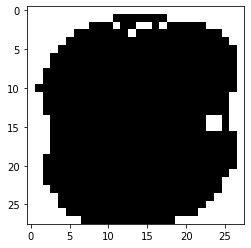

In [122]:
img = 1- (torch.sigmoid(model.sample_img())>0.5).int().squeeze().numpy()
plt.imshow(img, cmap=plt.cm.gray)

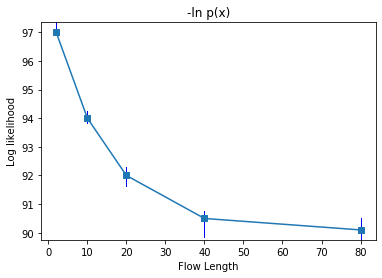

In [130]:
# Plot function for Figure 4
def plot_line_graph_(x_val, y_val, title=None, x_label=None, y_label=None, vertical_arr=None):
    min_ = np.min(y_val)
    yratio = np.max(y_val) - np.min(y_val)
    if vertical_arr is not None:
        for i,x in enumerate(x_val):
            if len(vertical_arr) > i:
                ymin = (1.0 * (vertical_arr[i][0]-min_)/yratio)
                ymax = (1.0 * (vertical_arr[i][1]-min_)/yratio)
                # ymin and ymax is in percentage
                plt.axvline(x=x, ymin=ymin, ymax=ymax, linewidth=1, color='blue')
    plt.plot(x_val, y_val, marker='s')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)            


# Plot with Example of input (for flow length 2,10,20,40,80)
flow_length = [2,10,20,40,80]
variational_bound = [97, 94, 92, 90.5, 90.1]
vb_min_max = [[96.8,98],[93.8,94.2],[91.8,92.4],[90.2,91],[90,90.8]]
label = '-ln p(x)'
x_label = 'Flow Length'
y_label = 'Log likelihood'

plot_line_graph_(flow_length, variational_bound, title=label, x_label=x_label, y_label=y_label, vertical_arr=vb_min_max)

